# SANTANDER DATA MASTER - CIENTISTA DE DADOS

### Questão b) Classificar clientes de 1 a 5

Descrição: A segunda tarefa consiste em dar uma nota de 1 a 5 para cada cliente da base teste, respeitando a variável ‘TARGET’, isto é, o seu nível de satisfação, sendo 1 o mais insatisfeito e 5 o mais satisfeito. Ao dar essa nota deve-se ter em mente que
somente os clientes com nota 1 serão alvos de uma ação de retenção e que o objetivo dessa ação é maximizar o lucro esperado por cliente (usando os mesmos valores da primeira questão).

In [ ]:
!pip install scikit-learn
!pip install imblearn
!pip install xgboost

In [2]:
#Imports

#Manipulação dos Dados
import pandas as pd
import numpy as np

#Visualização dos Dados
import matplotlib.pyplot as plt
from matplotlib import rcParams
import seaborn as sns

from sklearn.model_selection import train_test_split
from sklearn.metrics import roc_auc_score as auc
from sklearn.metrics import (make_scorer, confusion_matrix,
                             silhouette_score, roc_curve,
                             precision_recall_curve, classification_report)
from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import GradientBoostingClassifier
from imblearn.over_sampling import SMOTE
import xgboost as xgb



In [3]:
df_train = pd.read_pickle('./train_1.pickle')
df_test = pd.read_pickle('./test_1.pickle')

In [4]:
df_train.shape,df_test.shape

((76020, 142), (75818, 141))

In [5]:
X_train, X_test, y_train, y_test = train_test_split(df_train.drop(['TARGET','ID'], axis = 1), df_train.TARGET, stratify = df_train.TARGET, train_size = 0.80 ,random_state = 42)

Para realizar a atividade de dar nota de 1 a 5, usaremos como base de ordenação o modelo otimizado de Gradient Boosting. O método predict_proba trará a probabilidade até 1 da coluna TARGET, ou seja, quanto maior o valor, maior a chance do cliente ser instatisfeito.

In [6]:
params_rf = {'class_weight':'balanced',
             'max_leaf_nodes':250,
             'max_depth': 1000,
             'min_samples_leaf': 3,
             'min_samples_split': 100,
             'n_estimators': 2000,
             'random_state': 12345}

rf_optimized = RandomForestClassifier(**params_rf)
rf_optimized.fit(X_train, y_train)

RandomForestClassifier(class_weight='balanced', max_depth=1000,
                       max_leaf_nodes=250, min_samples_leaf=3,
                       min_samples_split=100, n_estimators=2000,
                       random_state=12345)

In [6]:
gradient_booster = GradientBoostingClassifier(learning_rate=0.1)
gradient_booster.fit(X_train, y_train)

GradientBoostingClassifier()

In [8]:
y_predicted = gradient_booster.predict_proba(X_test)[:,1]
auc(y_test, y_predicted)

0.8366622853739146

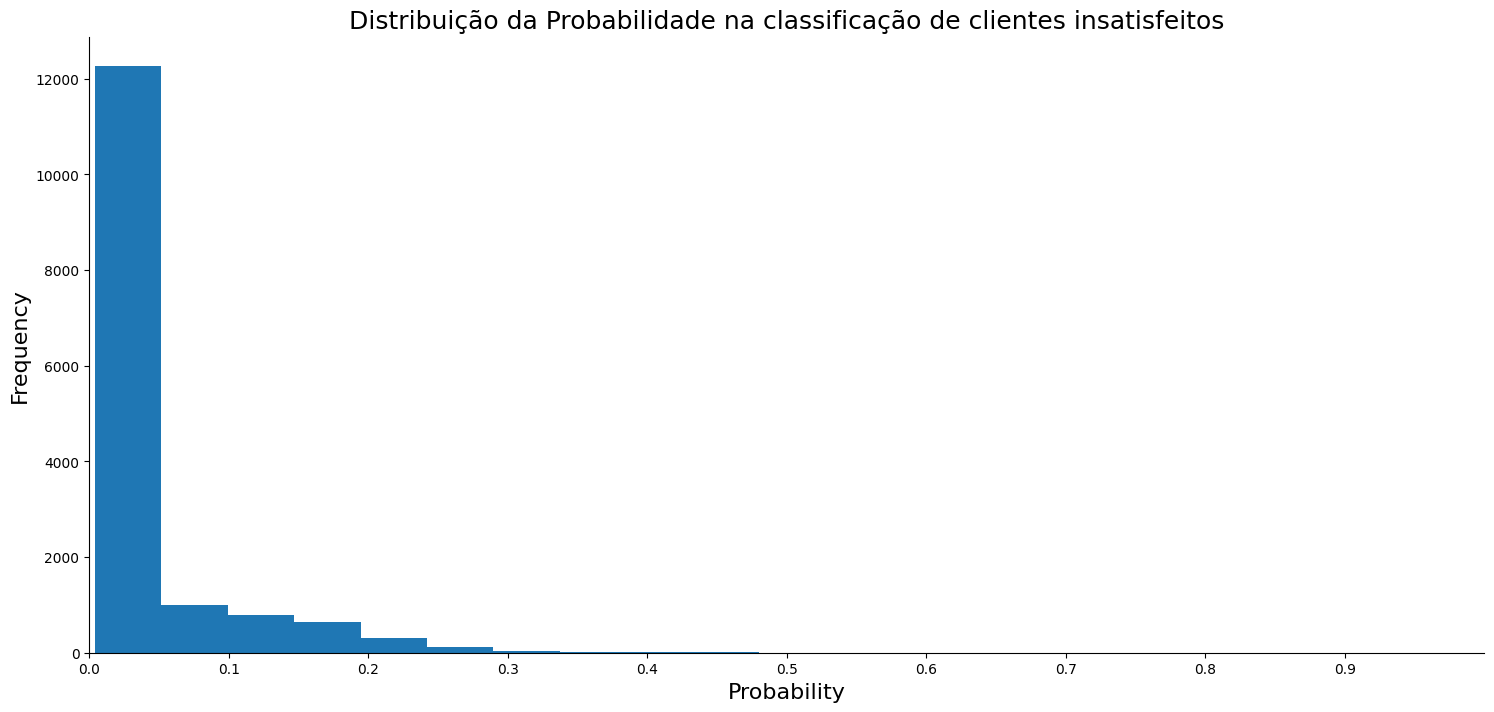

In [10]:
fig, ax = plt.subplots(figsize = (18, 8))
ax.hist(gradient_booster.predict_proba(X_test)[:,1], bins = 20);
ax.set_xlim(0, 1);
plt.xticks(np.arange(0, 1, 0.1))
plt.title('Distribuição da Probabilidade na classificação de clientes insatisfeitos', fontsize=18);
plt.ylabel('Frequency', fontsize=16);
plt.xlabel('Probability', fontsize=16);
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)

Conforme o gráfico acima, a probabilidades tem maior ocorrência até 0,3.

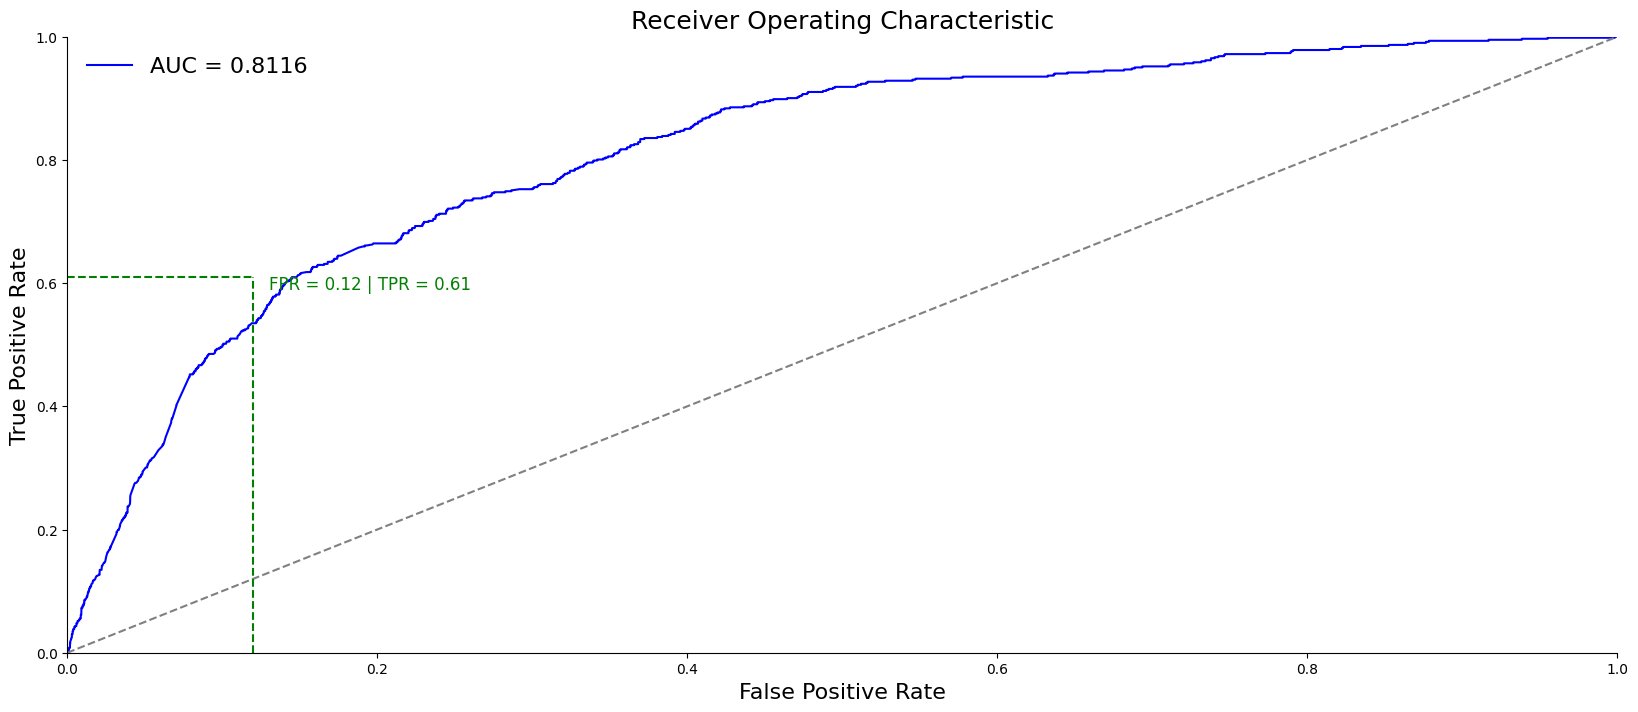

In [25]:
import sklearn.metrics as metrics

# Calculate FPR and TPR for all thresholds
fpr, tpr, threshold = metrics.roc_curve(y_test, y_predicted)
roc_auc = metrics.auc(fpr, tpr)

# Plotting the ROC curve
import matplotlib.pyplot as plt
fig, ax = plt.subplots(figsize = (20, 8))
plt.title('Receiver Operating Characteristic', fontsize=18)
plt.plot(fpr, tpr, 'b', label = 'AUC = %0.4f' % roc_auc)
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)
plt.legend(loc = 'upper left', fontsize = 16, frameon = False)
plt.plot([0, 1], [0, 1], color = 'grey', linestyle = '--')
plt.xlim([0, 1])
plt.ylim([0, 1])
plt.ylabel('True Positive Rate', fontsize = 16)
plt.xlabel('False Positive Rate', fontsize = 16)

ax.plot([0.12, 0.12], [0, 0.61], color='green', linestyle='dashed', label='FPR = 0.12')
ax.plot([0, 0.12], [0.61, 0.61], color='green', linestyle='dashed', label='FPR = 0.12')
plt.text(0.13, 0.59, 'FPR = 0.12 | TPR = 0.61', fontsize = 12, color = 'green')

plt.show()

In [11]:
y_pred_train = gradient_booster.predict(X_train)

In [12]:
y_pred_proba_train = gradient_booster.predict_proba(X_train)[:,1]
y_pred = gradient_booster.predict(X_test)
y_pred_proba = gradient_booster.predict_proba(X_test)[:,1]

In [13]:
pr, recall, thr = precision_recall_curve(y_test, y_pred_proba)
pr_train, recall_train, thr_train = precision_recall_curve(y_train, y_pred_proba_train)

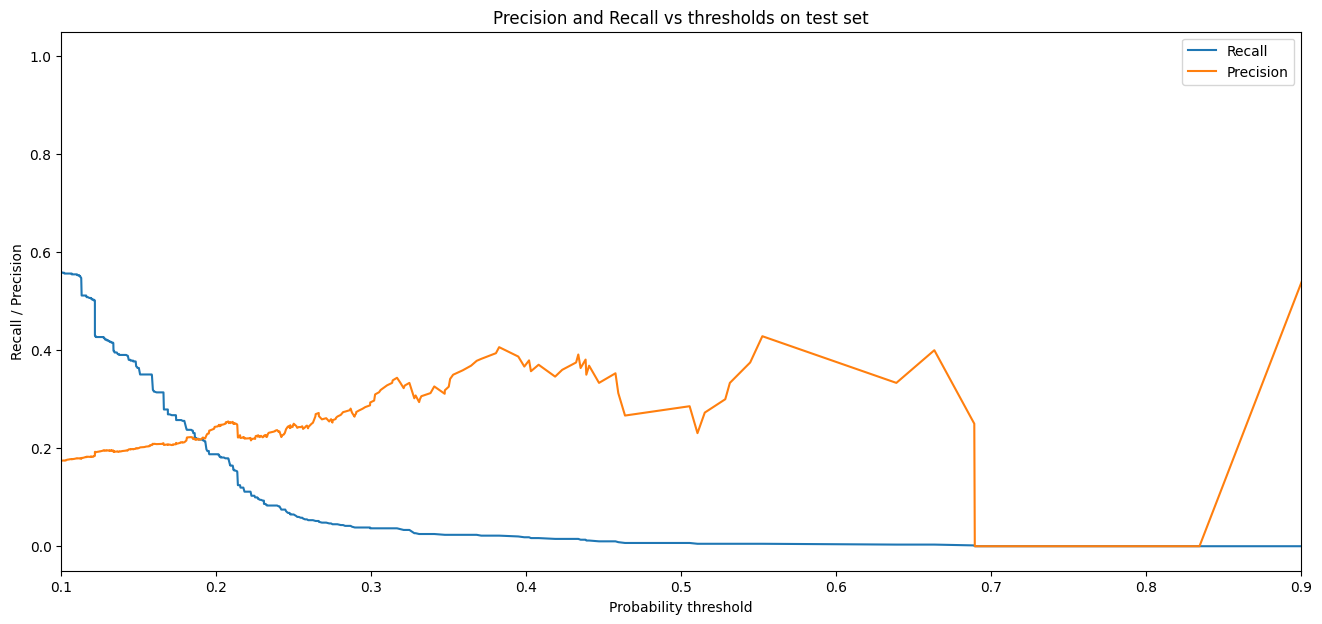

In [14]:
_ = plt.figure(figsize=(16,7))
_ = plt.plot(thr, recall[1:],label='Recall')
_ = plt.plot(thr, pr[1:],label='Precision')
_ = plt.xlabel('Probability threshold')
_ = plt.ylabel('Recall / Precision')
_ = plt.title('Precision and Recall vs thresholds on test set')
_ = plt.legend()
_ = plt.xlim([0.1,0.9])
plt.show()

In [15]:
def max_profit_score(y_true, y_pred):
    """
    Função que avalia o modelo computando o lucro esperado
    da ação de retenção dos clientes insatisfeitos.
    """
    conf_matrix = confusion_matrix(y_true, y_pred)
    
    FP = conf_matrix[0][1] # Falsos positivos
    TP = conf_matrix[1][1] # Verdadeiros positivos
    
    lucro = 90*TP - 10*FP # lucro da acao de retencao (os 
                          # verdadeiros e falsos negativos
                          # não contribuem em
                          # nada no lucro)
    print(FP, TP)
    return lucro

1291 551
1236 540
1218 535
1191 524
1060 493
999 475
897 454
822 440
815 435
755 418
677 399
667 393
604 369
579 363
567 358
549 356
527 344
448 306
412 296
377 283
359 270
343 267
333 263
321 254
263 226
246 215
238 213
225 204
211 198
198 191
175 184
164 181
157 176
144 169
135 165
128 164
126 164
116 162
110 155
103 151
99 145
93 141
78 135
76 133
74 133
70 130
70 126
63 116
58 113
54 110
52 107
50 106
49 104
48 104
45 102
45 101
43 97
43 96
43 96
40 95
39 95
35 94
35 93
31 92
29 89
28 88
25 86
23 86
20 85
19 85
18 84
18 84
18 84
16 82
15 81
14 80
13 79
13 78
12 78
12 77
12 77
12 77
11 77
11 76
11 75
11 75
10 74
9 73
8 71
8 71
8 71
8 71
8 70
8 70
8 68
8 67
8 67
8 66
8 66
7 63
7 63
6 62
6 62
6 62
6 62
6 62
6 62
6 60
6 60
6 57
6 57
6 57
6 56
6 55
5 54
5 54
4 53
4 53
4 53
4 53
4 53
4 52
4 52
4 51
4 50
4 49
4 48
3 45
3 45
3 45
3 45
3 45
3 45
3 45
3 45
3 45
3 45
3 45
3 44
2 43
1 43
1 42
1 42
1 42
1 41
0 41
0 40
0 40
0 38
0 38
0 38
0 38
0 38
0 37
0 37
0 37
0 37
0 37
0 37
0 37
0 37
0 37
0 

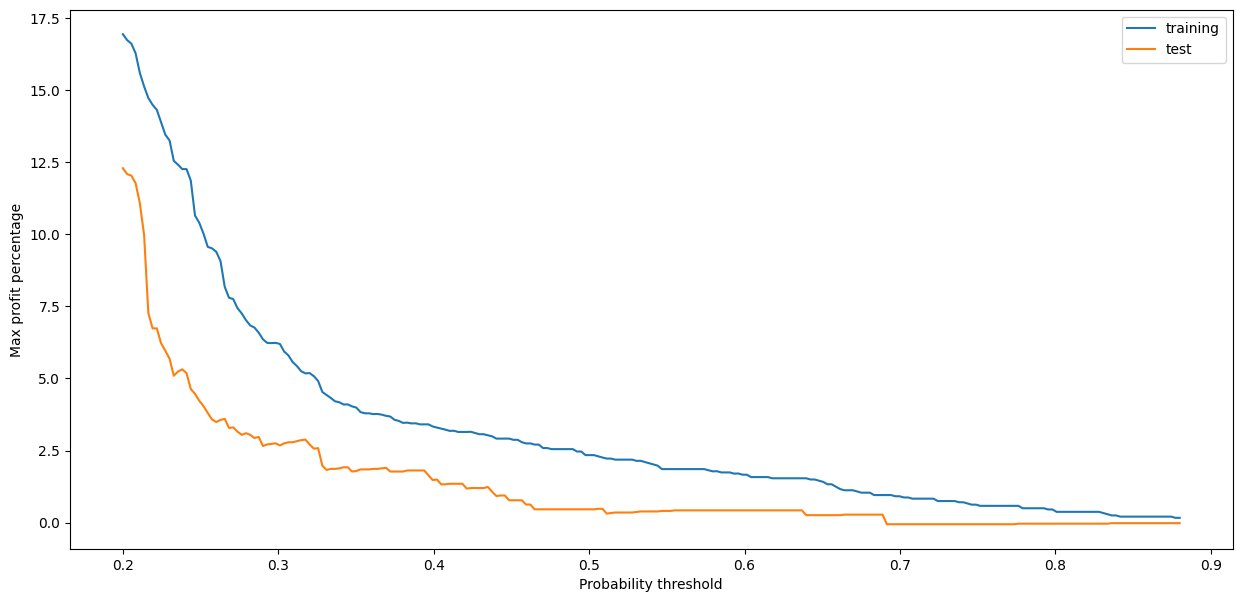

In [16]:
thresholds = np.linspace(0.2,0.88,250)
total_profit_percentage = [max_profit_score(y_train, (y_pred_proba_train > i)*1)/(y_train.sum()*90)*100 for i in thresholds]
total_profit_percentage_test = [max_profit_score(y_test, (y_pred_proba > i)*1)/(y_test.sum()*90)*100 for i in thresholds]
_ = plt.figure(figsize=(15,7))
_ = plt.plot(thresholds, total_profit_percentage, label='training')
_ = plt.plot(thresholds, total_profit_percentage_test, label='test')
_ = plt.ylabel('Max profit percentage')
_ = plt.xlabel('Probability threshold')
_ = plt.legend()

In [17]:

threshold_for_max_profit = thresholds[np.argmax(total_profit_percentage)]
print(threshold_for_max_profit)


0.2


In [18]:
print(classification_report(y_test, (y_pred_proba > threshold_for_max_profit)*1) )

              precision    recall  f1-score   support

           0       0.97      0.98      0.97     14602
           1       0.24      0.19      0.21       602

    accuracy                           0.94     15204
   macro avg       0.61      0.58      0.59     15204
weighted avg       0.94      0.94      0.94     15204



In [19]:
notas = pd.cut(y_pred_proba, bins=list(np.linspace(0,threshold_for_max_profit,5))+[1.0], labels=[5,4,3,2,1])

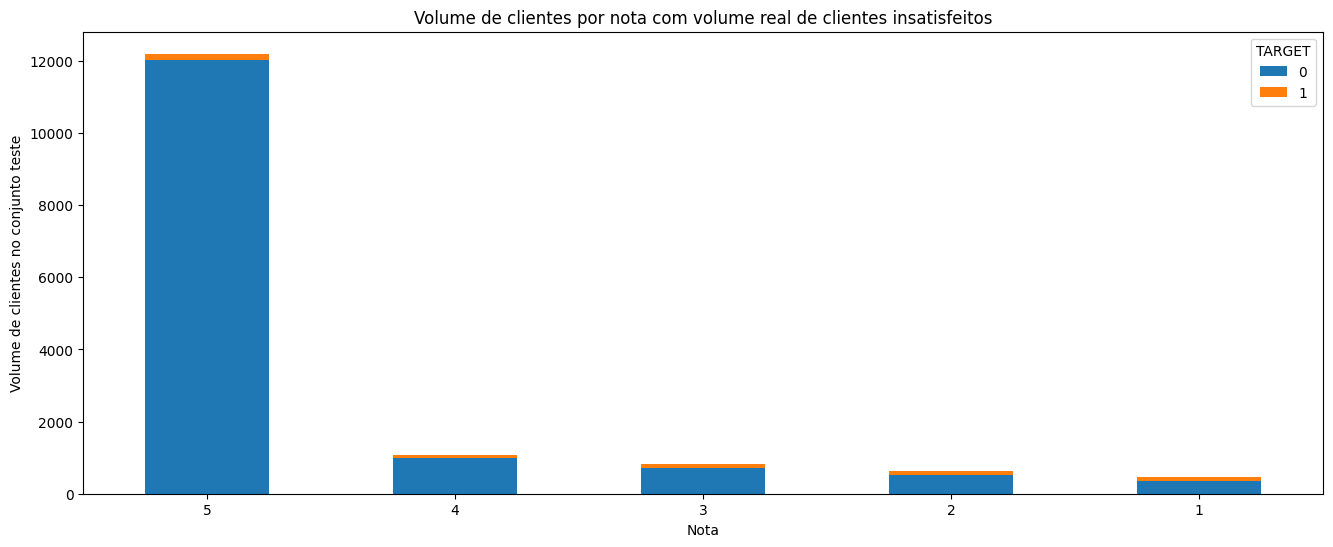

In [20]:
_ = pd.concat((pd.Series(notas, name='notas'), y_test.reset_index(drop=True)), axis=1, ignore_index=False).\
    groupby(['TARGET','notas']).size().unstack('TARGET').plot.bar(stacked=True,figsize = (16,6))
_ = plt.xticks(rotation=0)
_ = plt.ylabel('Volume de clientes no conjunto teste')
_ = plt.xlabel('Nota')
_ = plt.title('Volume de clientes por nota com volume real de clientes insatisfeitos')

In [21]:
print("Lucro total das notas 1 no conjunto de treinamento: R$ "+str(max_profit_score(y_test, (notas == 1)*1)))
print("Representando "+str(round(max_profit_score(y_test, (notas == 1)*1)/(y_test.sum()*90)*100,1))+ "% do máximo lucro possível no conjunto de teste.")


351 113
Lucro total das notas 1 no conjunto de treinamento: R$ 6660
351 113
Representando 12.3% do máximo lucro possível no conjunto de teste.
